# Discrete gamma hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

In our experiment we want to hedge a portfolio composed by an European call options that at time $T$ pays $X = (S(T) - K_1)^+$ where $K_1 > 0$ is the strike price. The pricing function of this call options is denoted with $F(t, s)$.

Since we cannot gamma hedge the call options with the underlying itself (the gamma of the underlying is zero) we are going to introduce another derivative in our hedging portfolio. For this purpose I've chosen a call options that at time $T_1 > T$ pays $Y = (S(T) - K_2)$, where $K_2 > K_1$ is the strike price of this options. The pricing function of this call options is denoted with $G(t, s)$. 

The experiment will be performed with the following parameters:
$$
S(0) = 100 \\
\mu = 0.0 \\
\sigma = 0.2 \\
K_1 = 110 \\
K_2 = 120 \\
T = 1.0 \\
T_1 = 1.1 \\
r = 0.0 
$$

Furthermore, no transaction costs will be assumed.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european, gamma_european

In [2]:
seed = 0

In [3]:
s0 = 100
sigma = 0.2
mean = 0.0
maturity = 1.0
maturity_1 = 1.1
N = 252
dt = maturity / N
n_sim = 1
K_1 = 110
K_2 = 120
discount_rate = 0.0
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.2
mean = 0.0
kappa = 2.0
theta = 0.3
sigma = 0.3
rho = -0.6
dtype = jnp.float32

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
stock_path = heston_model.sample_paths(seed, maturity, N, n_sim)

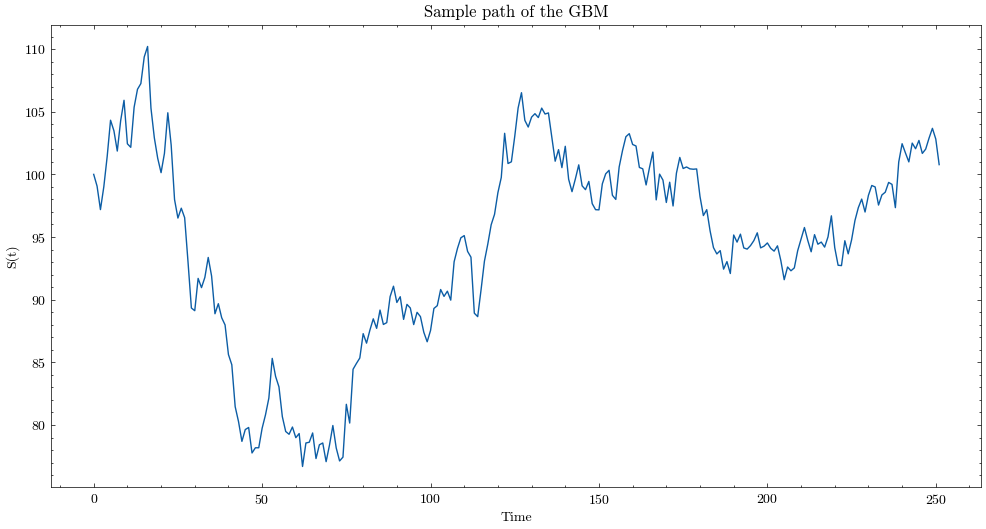

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path)
plt.title('Sample path of the GBM')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.show()

## Hedging experiment code

The gamma hedging will be done in the following way (Bjork, ed 4th, Cp.10.3):

With the portfolio assuming the following form:

$$
\Pi_t = - V_t * \omega S_t + \omega_1 V_t^1
$$

we have that the discrete change of the value of the portfolio is

$$
\Delta \Pi_t = - \Delta V_t + \omega \Delta S_t + \omega_1 \Delta V_t^1 + r(\omega S_t - V_t + \omega_1 V_t^1) \Delta t
$$

Since we want to minimize the variance of $\Delta \Pi_t$ with respect to $\omega$, i.e

$$
\min_{\omega} \mathbb{V}[\Delta \Pi_t] 
$$


we obtain that the optimal weights are 

- $\omega_1 = \frac{\Gamma_t^V}{\Gamma_t^{V^1}}$
- $\omega = \frac{\Delta^{V^1} \Gamma_t^V}{\Gamma_t^{V^1}} - \Delta^V$


In [11]:
stock_path[2]

Array([97.18825], dtype=float32)

In [20]:
gammas_f = [gamma_european(stock_path[0, 0], K_1, maturity - (i * dt), theta, discount_rate) for i in range(0, N)]
gammas_g = [gamma_european(stock_path[0, 0], K_2, maturity_1 - (i * dt), theta, discount_rate) for i in range(0, N)]
x_g = [gammas_f[i] / gammas_g[i] for i in range(0, N)]
deltas_f = [delta_european(stock_path[0, 0], K_1, maturity - (i * dt), theta, discount_rate) for i in range(0, N)]
deltas_g = [delta_european(stock_path[0, 0], K_2, maturity_1 - (i * dt), theta, discount_rate) for i in range(0, N)]
x_s = [-((deltas_g[i] * gammas_f[i] / gammas_g[i]) - deltas_f[i]) for i in range(0, N)]
p_call_price = [european_price(stock_path[i], K_1, maturity - (i * dt), theta, discount_rate) for i in range(0, N)]
h_call_price = [european_price(stock_path[i], K_2, maturity_1 - (i * dt), theta, discount_rate) for i in range(0, N)]
bank_account = [p_call_price[0] - (x_g[0] * h_call_price[0] + x_s[0] * stock_path[0])]
vs = [p_call_price[0]]

for i in range(1, N):
    vs.append(x_g[i - 1] * h_call_price[i] + x_s[i - 1] * stock_path[i] + bank_account[i - 1])
    bank_account.append(vs[i] - (x_g[i] * h_call_price[i] + x_s[i] * stock_path[i]))

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path - K_1, 0)

In [21]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  [0.31725377]


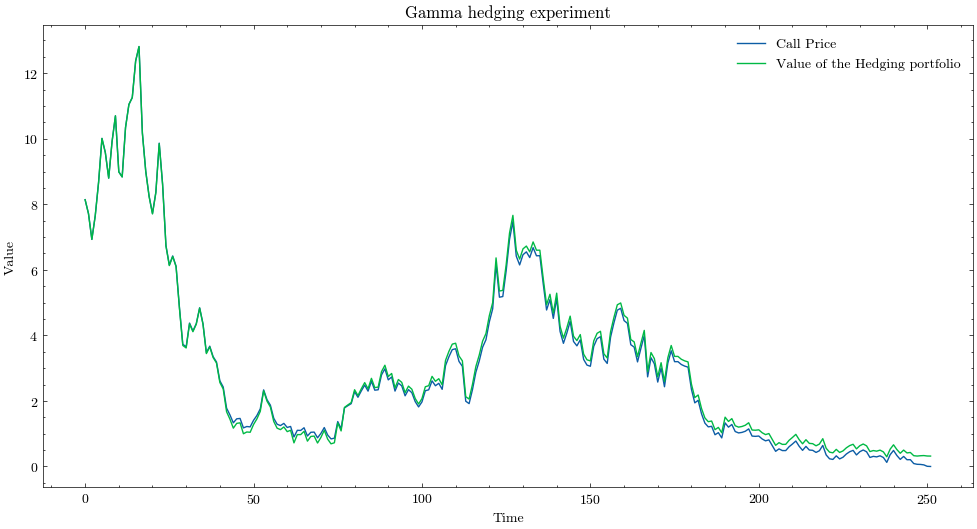

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(p_call_price, label='Call Price')
plt.plot(vs, label='Value of the Hedging portfolio')
plt.legend()
plt.title('Gamma hedging experiment')
plt.xlabel('Time')
plt.ylabel('Value')

plt.show()